# Fine-tuning a masked language model

There are a few cases where you’ll want to first fine-tune the language models on your data, before training a task-specific head. For example, if your dataset contains legal contracts or scientific articles, a vanilla Transformer model like BERT will typically treat the domain-specific words in your corpus as rare tokens, and the resulting performance may be less than satisfactory. By fine-tuning the language model on in-domain data you can boost the performance of many downstream tasks, which means you usually only have to do this step once!

This process of fine-tuning a pretrained language model on in-domain data is usually called ***domain adaptation. ***

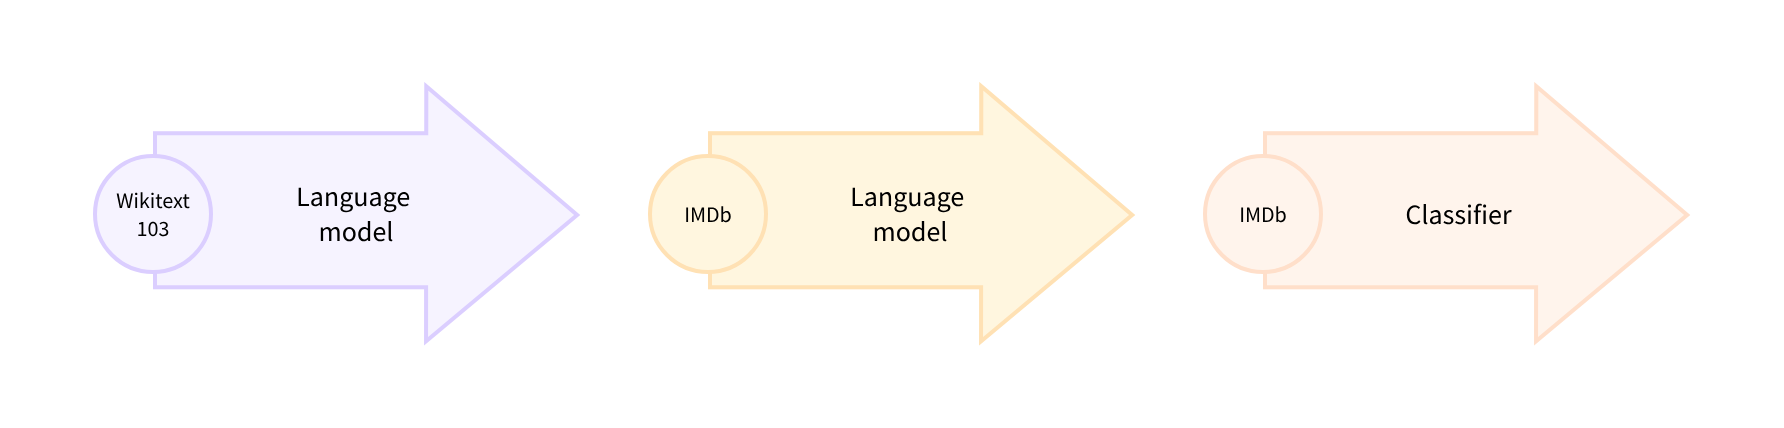

# Picking a pretrained model for masked language modeling

To get started, let’s pick a suitable pretrained model for masked language modeling. You can find a list of candidates by applying the “Fill-Mask” filter on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=fill-mask&sort=downloads):

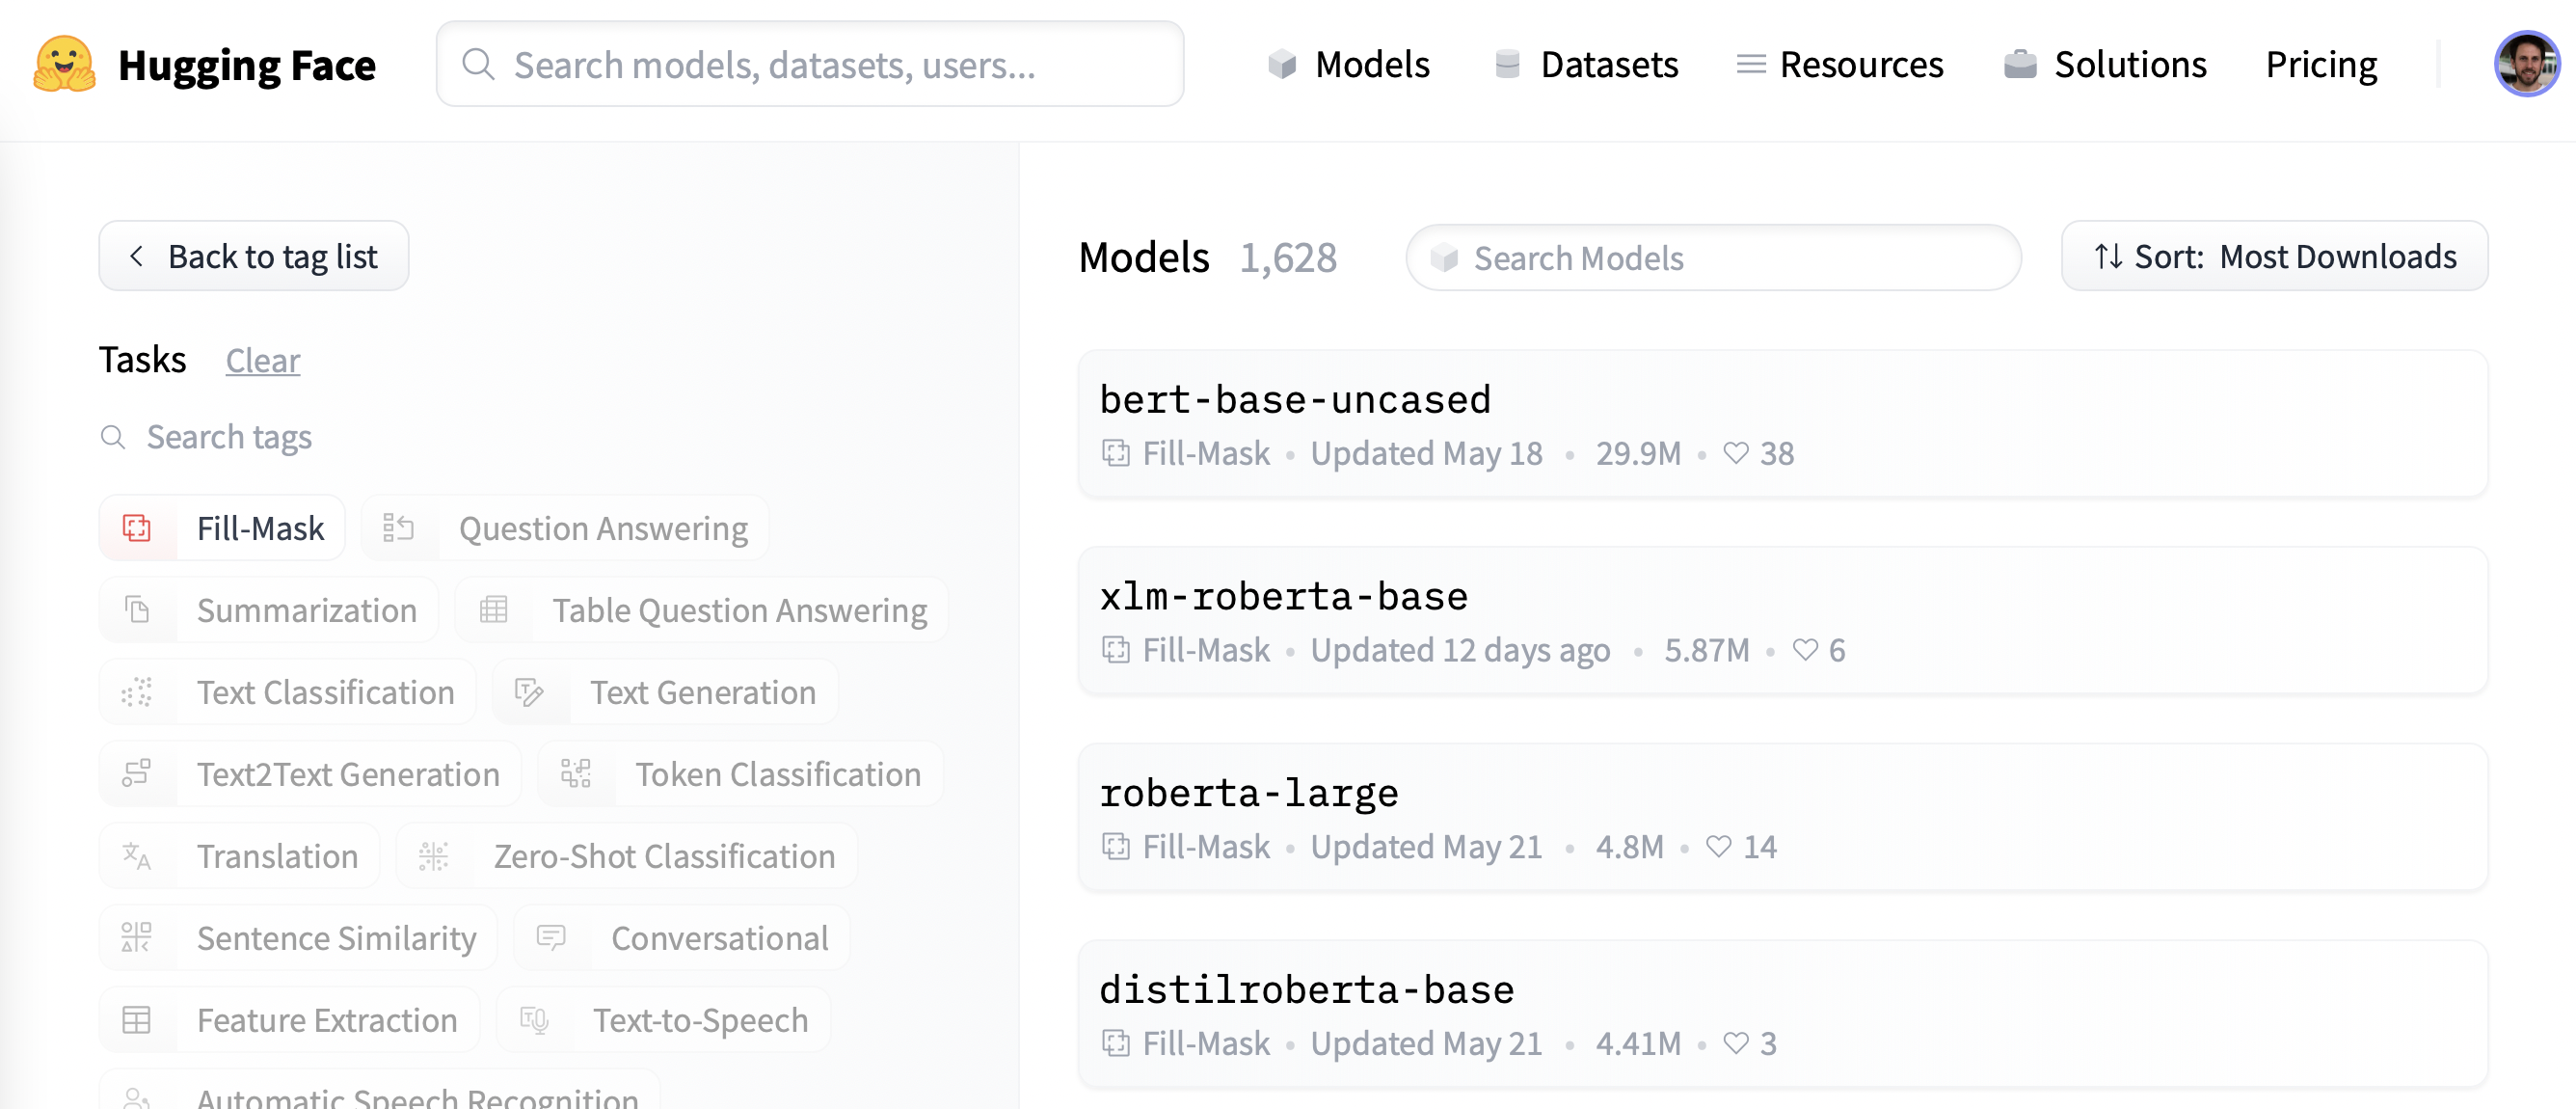

Although the BERT and RoBERTa family of models are the most downloaded, we’ll use a model called [DistilBERT](https://huggingface.co/distilbert-base-uncased) that can be trained much faster with little to no loss in downstream performance. This model was trained using a special technique called knowledge distillation, where a large “teacher model” like BERT is used to guide the training of a “student model” that has far fewer parameters.

Let’s go ahead and download `DistilBERT` using the `AutoModelForMaskedLM` class:

In [1]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

We can see how many parameters this model has by calling the `num_parameters()` method:

In [2]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f">>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M")
print(">>> BERT number of parameters: 110M")

>>> DistilBERT number of parameters: 67M
>>> BERT number of parameters: 110M


With around 67 million parameters, DistilBERT is approximately two times smaller than the BERT base model, which roughly translates into a two-fold speedup in training — nice! Let’s now see what kinds of tokens this model predicts are the most likely completions of a small sample of text:

In [3]:
text = "This is a great [MASK]."

As humans, we can imagine many possibilities for the `[MASK]` token, such as “day”, “ride”, or “painting”. For pretrained models, the predictions depend on the corpus the model was trained on, since it learns to pick up the statistical patterns present in the data. Like BERT, DistilBERT was pretrained on the [English Wikipedia](https://huggingface.co/datasets/wikipedia) and [BookCorpus](https://huggingface.co/datasets/bookcorpus) datasets, so we expect the predictions for `[MASK]` to reflect these domains. To predict the mask we need DistilBERT’s tokenizer to produce the inputs for the model, so let’s download that from the Hub as well:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

With a tokenizer and a model, we can now pass our text example to the model, extract the logits, and print out the top 5 candidates:



In [5]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits  # shape (batch_size, sequence_length, vocab_size)

# Find the location of [MASK] and extract
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
# Extract the logits for the [MASK] token from the last layer
mask_token_logits = token_logits[0, mask_token_index]  # shape (masked_token_count, vocab_size)

# Pick the [MASK] candidates with the highest logits
# topk returns the indices and values
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices  # shape (masked_token_count, top_k)
example_top_5_tokens = top_5_tokens[0].tolist()  # Take the top_k for the first example in the batch

for token in example_top_5_tokens:
    # tokenizer.mask_token => '[MASK]'
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great deal.
>>> This is a great success.
>>> This is a great adventure.
>>> This is a great idea.
>>> This is a great feat.


We can see from the outputs that the model’s **predictions refer to everyday terms**, which is perhaps not surprising given the foundation of English Wikipedia. **Let’s see how we can change this domain** to something a bit more niche — highly polarized movie reviews!

# The dataset

To showcase domain adaptation, we’ll use the famous [Large Movie Review Dataset](https://huggingface.co/datasets/imdb) (or IMDb for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models. By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews. We can get the data from the Hugging Face Hub with the `load_dataset()` function from Hugging Face Datasets:

In [6]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We can see that the `train` and test `splits` each consist of 25,000 reviews, while there is an unlabeled split called `unsupervised` that contains 50,000 reviews. Let’s **take a look at a few samples** to get an idea of what kind of text we’re dealing with. We’ll chain the `Dataset.shuffle()` and `Dataset.select()` functions to create a random sample:

In [7]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n>>> Review: {row['text']}")
    print(f">>> Label: {row['label']}")


>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
>>> Label: 1

>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub you

Yep, these are certainly movie reviews. Although we won’t need the labels for language modeling, we can already see that a 0 denotes a negative review, while a 1 corresponds to a positive one.

## Preprocessing the data

We just need a dataset of texts, no labels are needed, as is a sel-supervised problem.

**For both auto-regressive and masked language modeling**, a common preprocessing step is to **concatenate all the examples** and then **split the whole corpus into chunks of equal size**. This is quite different from our usual approach, where we simply tokenize individual examples. Why concatenate everything together? The reason is that individual examples might get truncated if they’re too long, and that would result in losing information that might be useful for the language modeling task!

So to get started, we’ll first tokenize our corpus as usual, but **without setting** the `truncation=True` option in our tokenizer. We’ll also grab the word IDs if they are available, as we will need them later on to do whole word masking. We’ll wrap this in a simple function, and while we’re at it we’ll remove the text and label columns since we don’t need them any longer:

In [8]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text", "label"]  # We don't need them for MLM, will set labels later
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

Since DistilBERT is a BERT-like model, we can see that the encoded texts consist of the `input_ids` and `attention_mask` that we’ve seen in other chapters, as well as the `word_ids` we added.

Now that we’ve tokenized our movie reviews, the next step is to group them all together and split the result into chunks. But how big should these chunks be? This will ultimately be determined by the amount of GPU memory that you have available, but a good starting point is to see what the model’s maximum context size is. This can be inferred by inspecting the `model_max_length` attribute of the tokenizer:

In [9]:
tokenizer.model_max_length

512

This value is derived from the tokenizer_config.json file associated with a checkpoint; in this case we can see that the context size is 512 tokens, just like with BERT. So, in order to run our experiments on GPUs like those found on Google Colab, we’ll pick something a bit smaller that can fit in memory:

In [10]:
chunk_size = 128

> Note that **using a small chunk size can be detrimental** in real-world scenarios, so you should use a size that corresponds to the use case you will apply your model to.

Now comes the fun part. To show how the concatenation works, let’s take a few reviews from our tokenized training set and print out the number of tokens per review:

In [11]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f">>> Review {idx} length: {len(sample)}")

>>> Review 0 length: 363
>>> Review 1 length: 304
>>> Review 2 length: 133


We can then concatenate all these examples with a simple dictionary comprehension, as follows:

In [12]:
concatenated_examples = {}
for key in tokenized_samples.keys():  # input_ids, attention_mask, word_ids
    concatenated_examples[key] = []  # Initialize empty list
    for field_data in tokenized_samples[key]:  # Iterate over the cases for the current key
        concatenated_examples[key].extend(field_data)  # Concatenate the values - extend
total_length = len(concatenated_examples["input_ids"])
print(f">>> Concatenated reviews length: {total_length}")

>>> Concatenated reviews length: 800


Great, the total length checks out — so now let’s **split the concatenated reviews into chunks** of the size given by `chunk_size`. To do so, we iterate over the features in `concatenated_examples` and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:

In [13]:
chunks = {}
for field_name, concatenated_info in concatenated_examples.items():
    chunks[field_name] = []  # Initialize empty list of chunks data
    for i in range(0, total_length, chunk_size):  # Iterate over the concatenated info in chunk_size steps
        chunk = concatenated_info[i : i + chunk_size]  # Slice the concatenated info
        chunks[field_name].append(chunk)  # Append the chunk to the list instead of concatenating

for chunk in chunks["input_ids"]:
    print(f">>> Chunk length: {len(chunk)}")

>>> Chunk length: 128
>>> Chunk length: 128
>>> Chunk length: 128
>>> Chunk length: 128
>>> Chunk length: 128
>>> Chunk length: 128
>>> Chunk length: 32


As you can see in this example, the **last chunk will generally be smaller** than the maximum chunk size. There are two main strategies for dealing with this:

- **Drop** the last chunk if it’s smaller than `chunk_size`.
- **Pad** the last chunk until its length equals `chunk_size`.

We’ll take the first approach here, so let’s wrap all of the above logic in a single function that we can apply to our tokenized datasets:

In [14]:
def group_texts(examples):
    # Concatenate all texts in examples batch
    concatenated_examples = {}
    for key in examples.keys():  # input_ids, attention_mask, word_ids
        concatenated_examples[key] = []  # Initialize empty list
        for field_data in examples[key]:  # Iterate over the cases for the current key
            concatenated_examples[key].extend(field_data)  # Concatenate the values - extend

    # Compute length of concatenated texts
    total_length = len(concatenated_examples["input_ids"])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size

    # Split by chunks of max_len
    result = {}
    for field_name, concatenated_data in concatenated_examples.items():
        result[field_name] = []  # Initialize empty list of chunks data
        for i in range(0, total_length, chunk_size):  # Iterate over the concatenated info in chunk_size steps
            chunk = concatenated_data[i : i + chunk_size]  # Slice the concatenated info
            result[field_name].append(chunk)  # Append the chunk to the list instead of concatenating

    # Create a new labels column as a copy of the input_ids, we will later "mask" it
    result["labels"] = result["input_ids"].copy()
    return result

Note that in the last step of `group_texts()` we create a **new labels column which is a copy of the `input_ids`** one. As we’ll see shortly, that’s because in masked language modeling the objective is to predict randomly masked tokens in the input batch, and by creating a labels column we provide the ground truth for our language model to learn from.

Let’s now apply `group_texts()` to our tokenized datasets using our trusty `Dataset.map()` function:

In [15]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

You can see that grouping and then chunking the texts has produced many more examples than our original 25,000 for the train and test splits. That’s because we now have examples involving contiguous tokens that span across multiple examples from the original corpus. You can see this explicitly by looking for the special `[SEP]` and `[CLS]` tokens in one of the chunks:

In [16]:
tokenizer.decode(lm_datasets["train"][2]["input_ids"])

'arguably their answer to good old boy john ford, had sex scenes in his films. < br / > < br / > i do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in america. i am curious - yellow is a good film for anyone wanting to study the meat and potatoes ( no pun intended ) of swedish cinema. but really, this film doesn\'t have much of a plot. [SEP] [CLS] " i am curious : yellow " is a risible and pretentious steaming pile. it doesn'

Let’s also check out what the labels look like for masked language modeling:

In [17]:
tokenizer.decode(lm_datasets["train"][2]["labels"])

'arguably their answer to good old boy john ford, had sex scenes in his films. < br / > < br / > i do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in america. i am curious - yellow is a good film for anyone wanting to study the meat and potatoes ( no pun intended ) of swedish cinema. but really, this film doesn\'t have much of a plot. [SEP] [CLS] " i am curious : yellow " is a risible and pretentious steaming pile. it doesn'

As expected from our `group_texts()` function above, this looks identical to the decoded `input_ids` — but then how can our model possibly learn anything? We’re missing a key step: **inserting `[MASK]` tokens at random positions in the inputs**! Let’s see how we can do this on the fly during fine-tuning using a special **data collator**.

## MLM Data Collator

Fine-tuning a masked language model is almost identical to fine-tuning a sequence classification model. The only difference is that we need a special data collator that can randomly mask some of the tokens in each batch of texts. Fortunately, Hugging Face Transformers comes prepared with a dedicated [`DataCollatorForLanguageModeling`](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorForLanguageModeling) for just this task. We just have to pass it the tokenizer and an `mlm_probability` argument that specifies what fraction of the tokens to mask. We’ll pick 15%, which is the amount used for BERT and a common choice in the literature:

In [18]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

To see how the random masking works, let’s feed a few examples to the data collator. Since it expects a list of `dicts`, where each dict represents a single chunk of contiguous text, we first iterate over the dataset before feeding the batch to the collator. We remove the "`word_ids`" key for this data collator as it does not expect it:

In [19]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n>>> {tokenizer.decode(chunk)}")


>>> [CLS] [MASK] rented i am curious - [MASK] [MASK] my video store because of all the controversy that [MASK] it when it was mall released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to [MASK] this algebra, therefore being a fan of films considered " controversial " i really had [MASK] see this for [MASK]. < br / > < br / > [MASK] plot is [MASK] around a young swedish [MASK] student named lena who wants to [MASK] everything she [MASK] [MASK] life. in particular she wants to [MASK] [MASK] attentions to making some [MASK] of documentary on what the average swede thought about [MASK] political issues such

>>> as the vietnam war and race issues [MASK] the united states. in between asking politicians and ordinary [MASK]izens of stockholm [MASK] their opinions on politics, she has [MASK] with her drama teacher, [MASK], and married [MASK]. [MASK] [MASK] / > < [MASK] / > [MASK] kills me about i am curious - [MASK] is that infinite years ago, this was 

In [20]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

batch = data_collator(samples)
for chunk_index in range(len(batch)-1):
    print(f"\n>>> {tokenizer.decode(batch["input_ids"][chunk_index])}")
    print(f">>> {batch["labels"][chunk_index].tolist()}")


>>> [CLS] i rented i am [MASK] - yellow from my video store because of all [MASK] controversy that surrounded [MASK] when it was first released [MASK] 1967 [MASK] i also heard that at first it was seized by u [MASK] s. [MASK] [MASK] it ever tried to enter this country, therefore being a fan of films considered " controversial " [MASK] really had to see this for myself. < br midwest > < br / > the streamlined is centered around a young swedish drama student named lena who wants to learn everything she [MASK] about life. in particular she wants to focus her attentions to making some sort of documentary on– the average sw [MASK] thought about certain political issues such
>>> [-100, -100, -100, -100, -100, 8025, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1996, -100, -100, -100, 2009, -100, -100, -100, -100, -100, 1999, 3476, 1012, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1012, -100, -100, 8205, 2065, -100, -100, -100, -100, -100, -100, -100, -100, -100

Nice, it worked! We can see that the `[MASK]` token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training — and the beauty of the data collator is that it **will randomize the `[MASK]` insertion with every batch**!

### Custom Whole Word Masking Collator

When training models for masked language modeling, one technique that can be used is to mask whole words together, not just individual tokens. This approach is called whole word masking. If we want to use ***whole word masking***, we will need to build a data collator ourselves. A data collator is just a function that takes a list of samples and converts them into a batch, so let’s do this now! We’ll use the word IDs computed earlier to make a map between word indices and the corresponding tokens, then randomly decide which words to mask and apply that mask on the inputs. Note that the **labels are all -100 except for the ones corresponding to mask words**.

In [21]:
import collections
import numpy as np

from transformers import default_data_collator

In [22]:
wwm_probability = 0.2  # probability of masking a word for WWM

def whole_word_masking_data_collator(features: list[dict]):
    """
    Data collator that will dynamically mask entire words based on WWM probability

    Args:
        features: List of dicts with the features (inputs_ids, labels, etc) to preprocess
    """
    for feature in features:  # Iterate over each item in the batch -> dict
        # list mapping each token to corresponding word id
        word_ids = feature.pop("word_ids")  # Ej: [None, 0, 0, 1, 2, 2, 2, None]

        # Create a map between words and corresponding token indices
        # The mapping will represent: {word_index: [token_index, token_index, ...], ...}
        mapping = collections.defaultdict(list)  # Will not take into account special tokens
        current_word_index = -1
        current_word = None
        for token_idx, word_id in enumerate(word_ids):  # Iterate over each word_id (as many as tokens)
            if word_id is not None:  # Skip special tokens (CLS, SEP, etc)
                if word_id != current_word:  # If we are in a new word
                    current_word = word_id  # Update current word
                    current_word_index += 1  # Update current word index
                mapping[current_word_index].append(token_idx)  # Append token index to current word

        # Randomly mask words
        # Set the mask to a array of 0s and 1s, where 1s indicate the words_ids to mask
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        # Iterate over each word we want to mask
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)  # Set initial labels to -100
        for word_id in np.where(mask)[0]:  # Iterate over the word_ids indices that are 1s (to mask)
            word_id = word_id.item()  # Get the word_id (index from the mapping)
            for idx in mapping[word_id]:  # For every token position related to the word to mask
                new_labels[idx] = labels[idx]  # Set label to the original token id (Language Model objective)
                input_ids[idx] = tokenizer.mask_token_id  # Set the token to mask token [MASK]
        
        feature["input_ids"] = input_ids  # Update the input_ids
        feature["labels"] = new_labels  # Update the labels

    return default_data_collator(features)

Next, we can try it on the same samples as before:

In [23]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] [MASK] [MASK] i am [MASK] - yellow from my video [MASK] because of all the controversy that surrounded it when it [MASK] first released in [MASK] [MASK] i also heard that [MASK] [MASK] it was seized by [MASK]. [MASK]. customs if it ever [MASK] to enter this country, therefore being a fan [MASK] films considered " controversial " i [MASK] had to see this for [MASK] [MASK] < br / > [MASK] br / > the plot is [MASK] around a young swedish drama student [MASK] lena who wants to learn everything she can about life. in particular she wants [MASK] focus her attentions to [MASK] some [MASK] [MASK] documentary [MASK] what the average swede thought about certain [MASK] issues such'

'>>> as the [MASK] [MASK] and race [MASK] in the united [MASK]. in between asking politicians and ordinary denizens of stockholm [MASK] their opinions on politics, she [MASK] sex with her [MASK] teacher [MASK] classmates [MASK] and [MASK] men. < br / > < br [MASK] [MASK] what kills me about i am curious - 

## Downsample the dataset

Now that we have two data collators, the rest of the fine-tuning steps are standard. Training can take a while, so we’ll first downsample the size of the training set to a few thousand examples. Don’t worry, we’ll still get a pretty decent language model! A quick way to downsample a dataset in Hugging Face Datasets is via the `Dataset.train_test_split()` function.

In [24]:
lm_datasets["train"]

Dataset({
    features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 61291
})

In [25]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

This has automatically created new train and test splits, with the training set size set to 10,000 examples and the validation set to 10% of that — feel free to increase this if you have a beefy GPU!

# Fine-tuning the model

Let's see how to fine-tune the model on the downsampled dataset.

## Pre-Masking the Evaluation Dataset

We saw that `DataCollatorForLanguageModeling` also applies **random masking with each evaluation**, so we’ll see some **fluctuations in our perplexity** scores with each training run. One way to eliminate this source of randomness is to **apply the masking once on the whole test** set, and then use the default data collator in Hugging Face Transformers to collect the batches during evaluation. To see how this works, let’s implement a simple function that applies the masking on a batch, similar to our first encounter with `DataCollatorForLanguageModeling`:

In [26]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = whole_word_masking_data_collator(features)  # or data_collator
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

Next, we’ll apply this function to our test set and drop the unmasked columns so we can replace them with the masked ones. 

In [27]:
# for our defined collator we need to maintain the word_ids to mask entire words
# downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

## Training

We can then set up the dataloaders as usual, but we’ll use the `default_data_collator` from Hugging Face Transformers for the evaluation set:

In [28]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 16
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=whole_word_masking_data_collator,
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=default_data_collator  # as we already masked entire words
)

Form here, we follow the standard steps with Hugging Face Accelerate. We need to specify the optimizer; we’ll use the standard AdamW:

In [32]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

With these objects, we can now prepare everything for training with the Accelerator object:

In [33]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Now that our model, optimizer, and dataloaders are configured, we can specify the learning rate scheduler as follows:

In [34]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

With that done, it’s just a simple matter of writing out the full training and evaluation loop:

In [35]:
model_name = model_checkpoint.split("/")[-1]
output_dir = f"tmp/mlm-pt_finetuning-imdb-{model_name}"
output_dir

'tmp/mlm-pt_finetuning-imdb-distilbert-base-uncased'

In [36]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
        # We don't need pad_across_processes because all tensors
        # were set to a chunk_size size
        loss = outputs.loss
        losses.append(
            accelerator.gather(  # Gather here is for multi-GPU training
                loss.repeat(  # Repeat to match the batch size for the data
                    batch_size
                )
            )
        )

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)

  0%|          | 0/1875 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 26.2395470997799
>>> Epoch 1: Perplexity: 24.57077273196551
>>> Epoch 2: Perplexity: 23.784922834939966


# Using our fine-tuned model

You can interact with your fine-tuned model easily using the `pipeline` API. Let’s see how our model performs on a few examples:

In [37]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask",
    model=output_dir,
    device=0
)

We can then feed the pipeline our sample text of “This is a great [MASK]” and see what the top 5 predictions are:

In [38]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> this is a great film.
>>> this is a great movie.
>>> this is a great idea.
>>> this is a great comedy.
>>> this is a great story.


Neat — our model has clearly adapted its weights to predict words that are more strongly associated with movies!